<center>
    <img src="images/OdooProfileScreenshot.png" alt="Odoo Community Forum Profile Screenshot" style="min-width: 300px;width: 50%;" />
</center>

# User Participation in the Odoo Community Forum

This notebook automatically collects data from a user profile using webscraping techniques and based on the collected data it visualizes basic statistics of the participation of this user in the Odoo Community Forum AKA Odoo Help Forum. A pie chart and a calendar heatmap per calendar year (similar to GitHub's contributions plot) are visualization tools employed in this notebook for visualizing the statistics of the user activity.

In order for this notebook to work, the file `secret.json` must be placed in the same directory as this notebook and it must contain the user credentials required to login into the Odoo Community Forum website (i.e. email and password) and the user ID from the Odoo Community Forum (the user ID can be seen in the URL of the user profile page of the forum).


In [1]:
from datetime import datetime, timedelta
nb_st = datetime.utcnow()
print(f"\nNotebook START time: {nb_st} UTC\n")


Notebook START time: 2022-08-20 10:17:16.118253 UTC



In [2]:
%%HTML
<style>
@media (max-width: 540px) {
  .output .output_subarea {
    max-width: 100%;
  }
}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('🔎 Show Python Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('⌦ Hide Python Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide();
    $('div.input:contains("%%HTML")').removeClass( "input")
    $('div.input:contains("%%capture")').removeClass("input")
  });
</script>
<form action="javascript:code_toggle()">
  <input type="submit" id="toggleButton" value="🔎 Show Python Code"
         class="btn btn-default btn-lg">
</form>


In [3]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
import calplot
import time
from pathlib import Path
import json

In [4]:
VERBOSE = False
QUICK_DEBUG_RUN = False

# Collect data from the user account via webscraping

Based on the User ID and credentials provided in the `secret.json` login into the user account. Once we are logged into the users account, we have access to all its data. we collect information from the profile and save the collected data locally into the JSON files under the directory named after the User ID in the local `data` directory.

In [5]:
with open("secret.json", "r") as f:
    s = json.loads(f.read())

if VERBOSE:
    display({k:s[k] for k in s if k != "password"})

if (any([k not in s for k in ["user_id", "email", "password"]])
    or any([not s[k] for k in s])):
    raise Exception("Please provide your credentials first!")    

In [6]:
USER_ID = s["user_id"]

In [7]:
USER_EMAIL, USER_PASSWORD = s["email"], s["password"]

In [8]:
user_data_dir = Path.cwd() / "data" / str(USER_ID)

In [9]:
if user_data_dir.is_dir():
    
    for f in user_data_dir.rglob("*"):
        try:
            f.unlink()
        except IsADirectoryError:
            pass
        
    for f in user_data_dir.rglob("*"):
        f.rmdir()
else:
    user_data_dir.mkdir(parents=True)

if VERBOSE:
    print("Local directory of the user data:",
          user_data_dir.relative_to(Path.cwd()))

## Login into the User Account

Login into the account and simultaneously go to the profile page by sending a POST request containing the `redirect` key with the desired URI which is undersood by the Odoo backend and it takes us directly to the users profile page.

In [10]:
base_URL = "https://www.odoo.com"
login_URL = urllib.parse.urljoin(base_URL, "/web/login")

login_payload = {
'login': USER_EMAIL,
'password': USER_PASSWORD,
'redirect': f'/profile/user/{USER_ID}'
}

In [11]:
session = requests.Session()

In [12]:
def raise_on_failure(response):
    status_msg = f"HTTP response status code: {response.status_code}"

    if not response.ok:
        raise Exception(status_msg)
    elif VERBOSE:
        print(status_msg)
    return response

response = raise_on_failure(session.get(login_URL))

In [13]:
soup = BeautifulSoup(response.text)

In [14]:
csrf_input = (soup
              .find("form", {"action": "/web/login", "method": "post"})
              .find("input", {"name": "csrf_token"})
             )

In [15]:
login_payload['csrf_token'] = csrf_input.get("value")

In [16]:
if VERBOSE:
    display({k:login_payload[k] for k in login_payload if k != "password"})

In [17]:
response = raise_on_failure(session.post(login_URL, data=login_payload))

In [18]:
soup = BeautifulSoup(response.text)

## Collect data of User Profile

In this section we are collecting profile data, such as:
- Name
- Website
- City
- Country
- Biography
- Date Joined
- Current rank
- Current xp
- Next rank
- xp required for the next rank
- Number of Positive votes received
- Number of Negative votes received
- Avatar image URL
- Current rank icon URL
- Next rank icon URL
- Next rank progress (%)

Data collected in this section is saved locally into the `data/"User ID"/user_profile.json` file.

In [19]:
def add_scheme_to_url(url):
    return urllib.parse.urlunparse(urllib.parse.urlparse(url, scheme="https"))

In [20]:
user_profile = {
    "ID": USER_ID,
    "Name": "",
    "Website": "",
    "Email": USER_EMAIL,
    "City": "",
    "Country": "",
    "Biography": "",
}

In [21]:
user_profile["Name"] = soup.select(
    ".o_wprofile_header .o_card_people_name")[0].text.strip()

try:
    user_profile["Website"] = soup.select(
        ".o_wprofile_header i.fa-globe")[0].parent.text.strip()
except IndexError as e:
    user_profile["Website"] = None

try:
    location_entries = soup.select(
        ".o_wprofile_header i.fa-map-marker")[0].find_next_siblings()
    
    if len(location_entries) > 0:
        user_profile["City"] = location_entries[0].text.strip()
    else:
        user_profile["City"] = None
    
    if len(location_entries) > 1:
        user_profile["Country"] = location_entries[1].find("span").text.strip()
    else:
        user_profile["Country"] = None
except IndexError as e:
    user_profile["City"] = None
    user_profile["Country"] = None

try:
    user_profile["Biography"] = soup.find("h5",
                                          string="Biography"
                                         ).find_next_sibling()
    
    if len(user_profile["Biography"].text.strip()) > 0:
        user_profile["Biography"] = str(user_profile["Biography"])
    else:
        user_profile["Biography"] = None
except Exception as e:
    user_profile["Biography"] = None


user_profile["Current rank"] = soup.select(
    ".o_wprofile_sidebar .o_wprofile_sidebar_top a")[0].text.strip()

user_profile["Current rank icon"] = add_scheme_to_url(
    soup.select(
        ".o_wprofile_sidebar .o_wprofile_sidebar_top img")[0].get("src"))

user_profile["Joined"] = soup.select(
    "table#o_wprofile_sidebar_table")[0].find("th",
                                              string="Joined"
                                             ).find_next_sibling().text.strip()


(
    user_profile["Positive votes"],
    user_profile["Negative votes"],
) = soup.select(
    "table#o_wprofile_sidebar_table"
)[0].find("th", string="Votes").find_next_sibling().text.strip().split()

(
    user_profile["Next rank"],
    user_profile["Current xp"],
    _,
    user_profile["Next rank xp"],
    _,
) = soup.select(
    "#o_wprofile_sidebar_collapse .o_wprofile_progress_circle")[0].text.split()

for key in ("Current xp", "Next rank xp", "Positive votes", "Negative votes"):
    user_profile[key] = int(user_profile[key].replace(",", ""))
    
user_profile["Next rank progress"] = (
    user_profile["Current xp"] / user_profile["Next rank xp"] * 100
)
user_profile["Next rank icon"] = add_scheme_to_url(
    soup.select(
        "#o_wprofile_sidebar_collapse .o_wprofile_progress_circle img"
    )[0].get("src")
)
user_profile["Avatar image"] =  add_scheme_to_url(
    soup.select_one(
        ".o_wprofile_pict").get("style").split("url(")[1].split(")")[0])

if VERBOSE:
    display(user_profile)

In [22]:
profile_data_file = user_data_dir/"user_profile.json"
with open(profile_data_file, "w") as f:
    f.write(json.dumps(user_profile))

if VERBOSE:
    print(f"Saved profile data into the \"{profile_data_file.relative_to(Path.cwd())}\"")

## Collect data of Badges

In this section we are collecting data for each badge received by the user:
- Badge name
- URL of the icon used to for the badge

Data collected in this section is saved locally into the `data/"User ID"/user_badges.json` file.

In [23]:
user_badges = [{
    "badge_url": add_scheme_to_url(badge.find("img").get("src")),
    "badge_name": badge.text.strip()
}
    for badge in soup.select("#profile_about_badge .card")]

if VERBOSE:
    print(f"\nUser has {len(user_badges)} badges:\n")
    display(user_badges)

In [24]:
with open(user_data_dir/"user_badges.json", "w") as f:
    f.write(json.dumps(user_badges))

## Collet data of Questions

In this section we are collecting data of questions related to the user, such as:
- Questions asked by the user
- Questions starred by the user (Favourite Questions)
- Questions followed by the user

And the data collected per question is:
- URL of the question
- Date of question being asked
- Votes (total)
- Title of the question
- Content of the question (i.e. the aqcual question)


Data collected in this section is saved locally into the `data/"User ID"/related_questions.json` file.

In [25]:
if VERBOSE:
    print("Number of related questions:", len(soup.select("#questions .card")))

In [26]:
%%capture

related_questions = {}

for question_section in soup.select("#questions >*"):
    section_name = question_section.select_one("h5:first-child").text.strip()
    related_questions[section_name] = []

    for q in question_section.select(".card"):
        time.sleep(np.random.randint(1, 4))  # rate limit just in case, be kind
        q_url = urllib.parse.urljoin(base_URL, q.select_one("a").get("href"))
        response = raise_on_failure(session.get(q_url))
        q_soup = BeautifulSoup(response.text)
        related_questions[section_name].append({
            "URL": q_url,
            "time": q_soup.select_one("article time").text.strip(),
            "votes": int(q_soup.select_one(".vote_count").text.strip()),
            "title": q_soup.select_one("article header").text.strip(),
            "content": str(
                q_soup.select_one("article .o_wforum_post_content")),
        })
        if QUICK_DEBUG_RUN:
            break
    if QUICK_DEBUG_RUN:
        break

In [27]:
if VERBOSE:
    for section_name in  related_questions:
        print(f"\n{section_name} ({len(related_questions[section_name])}):\n")
        
        if len(related_questions[section_name]) > 0:
            display(related_questions[section_name][0])
        else:
            print("This section is empty.")

In [28]:
with open(user_data_dir/"related_questions.json", "w") as f:
    f.write(json.dumps(related_questions))

## Collect data of Answers


In this section we are collecting data of answers posted by the user, per answer we collect:
- URL of the answer (which is URL of the question + fragment for the answer)
- Date of the answer
- Votes (total) of the answer
- Whether the answer is accepted or not
- Content of the answer (i.e. the aqcual answer)
- The following data of the Question addressed by the answer:
  - Date of the question
  - Votes (total) of the question
  - Title of the question
  - Content of the question (i.e. the aqcual question)


Data collected in this section is saved locally into the `data/"User ID"/answers.json` file.

In [29]:
if VERBOSE:
    print("Number of answers:", len(soup.select("#answers .card")))

In [30]:
%%capture
answers = []

for a in soup.select("#answers .card"):
    time.sleep(np.random.randint(1, 4))  # rate limit just in case, be kind
    a_url = urllib.parse.urljoin(base_URL, a.select_one("a").get("href"))
    a_html_id = "#{}".format(
        urllib.parse.urlparse(a_url).fragment.replace("-","_"))
    response = raise_on_failure(session.get(a_url))
    q_soup = BeautifulSoup(response.text)
    a_soup = q_soup.select_one(a_html_id)
    answers.append({
        "URL": a_url,
        "time": a_soup.select_one("time").text.strip(),
        "votes": int(a_soup.select_one(".vote_count").text.strip()),
        "accepted": "o_wforum_answer_correct" in a_soup.attrs["class"],
        "content": str(a_soup.select_one(".o_wforum_readable")),
        "answered_question": {
            "time": q_soup.select_one("article time").text.strip(),
            "votes": int(q_soup.select_one(".vote_count").text.strip()),
            "title": q_soup.select_one("article header").text.strip(),
            "content": str(
                q_soup.select_one("article .o_wforum_post_content")),
        }
    })
    if QUICK_DEBUG_RUN:
        break

In [31]:
if VERBOSE:
    print(f"\nAnswers ({len(answers)}):\n")

    if len(answers) > 0:
        display(answers[0])
    else:
        print("This user has not answered any question.")

In [32]:
with open(user_data_dir/"answers.json", "w") as f:
    f.write(json.dumps(answers))

## Collect data of Activity


In this section we are collecting data of the user activity log entries, per entry we collect:
- Type of the activity
- Time of the activity
- URL or the relevant activity

Data collected in this section is saved locally into the `data/"User ID"/activity.json` file.

In [33]:
if VERBOSE:
    print(len(soup.select("#activity .card")))

In [34]:
activity = [
    {
        "type": a.select_one(".card-body span:nth-child(1)").text,
        "time": a.select_one(".card-body span:nth-child(2)").text,
        "URL": urllib.parse.urljoin(
            base_URL,
            a.select_one(".card-body span:nth-child(3) a").get("href")),
    }
    for a in soup.select("#activity .card")
]

if VERBOSE:
    display(activity[:10])

In [35]:
with open(user_data_dir/"activity.json", "w") as f:
    f.write(json.dumps(activity))

## Collect data of Votes Given

In this section we are collecting data of votes given by the user, per vote we collect:
- Time of the vote
- Whether is the vote positive or negative
- The following data is collected for the relevant Question or Answer this vote is givn to:
  - Title
  - URL


Data collected in this section is saved locally into the `data/"User ID"/votes.json` file.


In [36]:
if VERBOSE:
    print(len(soup.select("#votes >div >div")))

In [37]:
votes = [
    {
        "time": next(v.children).strip(),
        "is_positive": "fa-thumbs-up" in v.select_one("span").attrs["class"],
        "title": v.select_one("a").text.strip(),
        "URL": urllib.parse.urljoin(base_URL, v.select_one("a").get("href"))
    }
    for v in soup.select("#votes >div >div") if v.select_one("span")
]

if VERBOSE:
    display(votes[:10])

In [38]:
with open(user_data_dir/"votes.json", "w") as f:
    f.write(json.dumps(votes))

# Visualize User Participation Data

Pie charts and calendar heatmaps are used here to visualize the following data of the user participation in the forum:
- Total number of questions/answers (pie chart)
- Total number of positive/negative Votes received (pie chart)
- Total number of positive/negative Votes given (pie chart)
- Number of questions per day (calendar heatmap)
- Number of answers per day (calendar heatmap)
- Number of various activities combined per day (calendar heatmap)

## Questions/Answers, Votes Received, Votes Given

Summary of questions/answers, votes received and votes given visualized as pie charts.

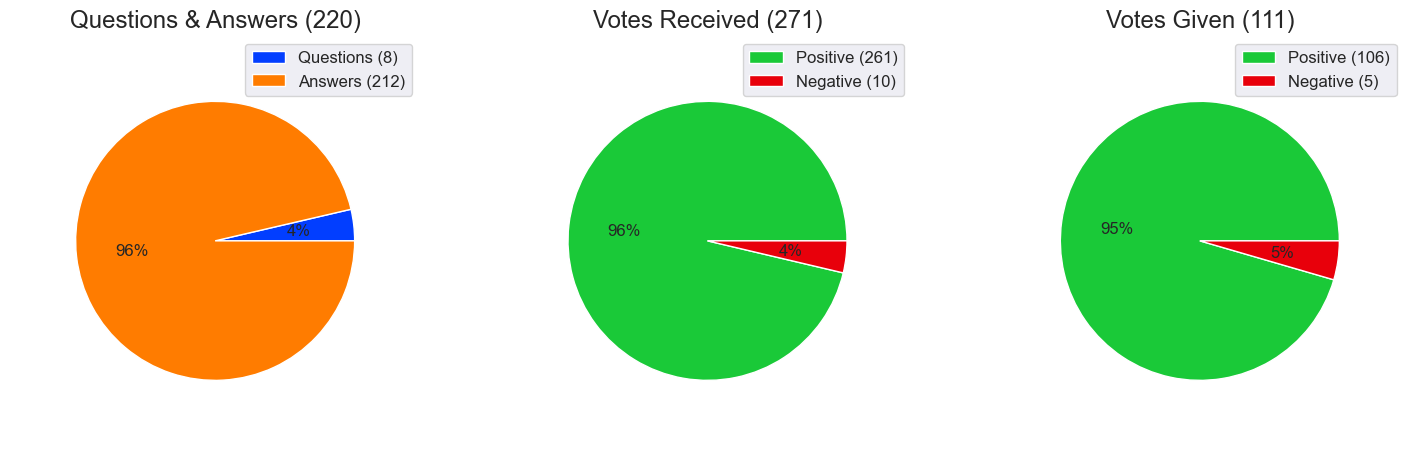

In [39]:
plt.show()
sns.set_theme()

fig, ax = plt.subplots(ncols=3, figsize=(6*3,9))

n_questions_asked = len(related_questions["Questions"])
n_questions_answered = len(answers)
ax[0].set_title(
    f"Questions & Answers ({n_questions_asked + n_questions_answered})",
    fontsize="x-large")
ax[0].pie([n_questions_asked, n_questions_answered], radius=0.85,
          colors=sns.color_palette('bright')[0:2], autopct='%.0f%%')
ax[0].legend(labels=[
    f"Questions ({n_questions_asked})",
    f"Answers ({n_questions_answered})",
], fontsize="medium", loc="upper right")

n_positive_votes_received = user_profile["Positive votes"]
n_negative_votes_received = user_profile["Negative votes"]
ax[1].set_title(
    "Votes Received "
    f"({n_positive_votes_received + n_negative_votes_received})",
    fontsize="x-large")
ax[1].pie([n_positive_votes_received, n_negative_votes_received], radius=0.85,
          colors=sns.color_palette('bright')[2:4],
          autopct='%.0f%%')
ax[1].legend(labels=[
    f"Positive ({n_positive_votes_received})",
    f"Negative ({n_negative_votes_received})",
], fontsize="medium", loc="upper right")

n_positive_votes_given = len([v for v in votes if v["is_positive"]])
n_negative_votes_given = len([v for v in votes if not v["is_positive"]])
ax[2].set_title(
    f"Votes Given ({n_positive_votes_given + n_negative_votes_given})",
    fontsize="x-large")
ax[2].pie([n_positive_votes_given, n_negative_votes_given], radius=0.85,
          colors=sns.color_palette('bright')[2:4], autopct='%.0f%%')
ax[2].legend(labels=[
    f"Positive ({n_positive_votes_given})",
    f"Negative ({n_negative_votes_given})"
], fontsize="medium", loc="upper right")
plt.show()

In [40]:
joined_day = datetime.strptime(user_profile["Joined"], "%d %b %Y").date()

if VERBOSE:
    print("User Joined on: ", joined_day)

In [41]:
related_question_days = {}

for section_name in  related_questions:
    related_question_days[section_name] = []
    for q in related_questions[section_name]:
        related_question_days[section_name].append(
            datetime.strptime(q["time"], "%d %B %Y").date())

In [42]:
if VERBOSE:
    for section_name in  related_questions:
        print(
            f"\nDays of {section_name} "
            f"({len(related_question_days[section_name])}):\n")
        
        if len(related_question_days[section_name]) > 0:
            display(related_question_days[section_name][0])
        else:
            print("This section is empty.")

In [43]:
answer_days = []

for answer in answers:
    answer_days.append(datetime.strptime(answer["time"], "%d %B %Y").date())

In [44]:
if VERBOSE:
    print(f"\nDays of Answers:\n")

    if len(answer_days) > 0:
        display(answer_days[0])
    else:
        print("This user has not answered any question.")

In [45]:
other_activity_days = []

for a in [x for x in activity if "New" not in x["type"]]:
    other_activity_days.append(
        datetime.strptime(a["time"], "%m/%d/%y, %I:%M %p").date())

In [46]:
if VERBOSE:
    print(f"\nDays of Activity:\n")

    if len(other_activity_days) > 0:
        display(other_activity_days[0])
    else:
        print("This user has no activity yet.")

In [47]:
vote_days = []

for v in votes:
    vote_days.append(
        datetime.strptime(v["time"].split(".")[0], "%Y-%m-%d %H:%M:%S").date())

In [48]:
if VERBOSE:
    print(f"\nDays of vote:\n")

    if len(vote_days) > 0:
        display(vote_days[0])
    else:
        print("This user gave no votes yet.")

## Questions Asked

Time series data of number of questions asked per day visualized as a calendar heatmap.

In [49]:
first_question_day = min(related_question_days["Questions"])
last_question_day = max(related_question_days["Questions"])

all_question_days = pd.date_range(first_question_day,
                                  last_question_day, freq="D")

if VERBOSE:
    print(f"Period of questions: {first_question_day} - {last_question_day}")

In [50]:
question_events = pd.Series(np.zeros(len(all_question_days)),
                            index=all_question_days, dtype=int)

for d in related_question_days["Questions"]:
    question_events.loc[pd.DatetimeIndex([d])] += 1

if VERBOSE:
    display(question_events)

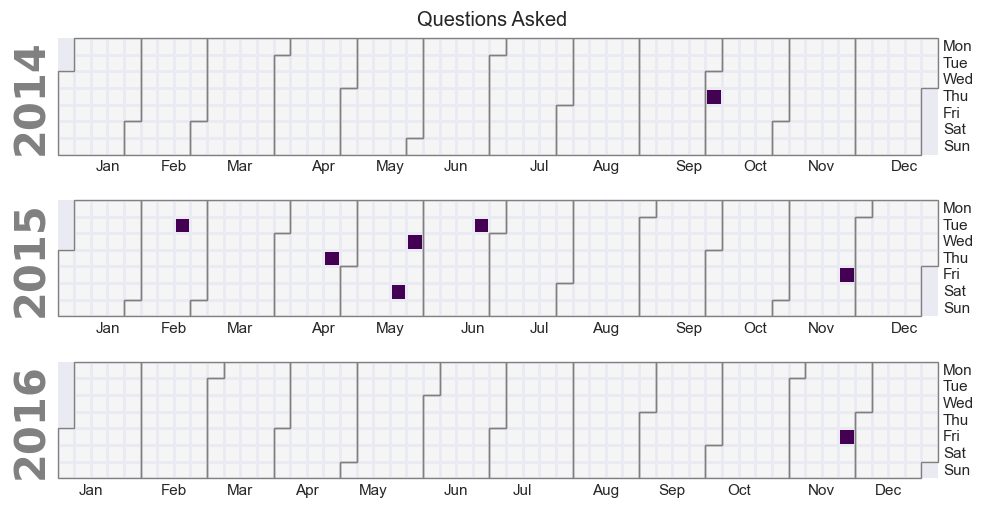

In [51]:
%%capture --no-display
calplot.calplot(question_events, how=None, suptitle="Questions Asked",
                colorbar=question_events.max() > 1)
plt.show()

## Answers Given

Time series data of number of answers posted per day visualized as a calendar heatmap.

In [52]:
first_answer_day = min(answer_days)
last_answer_day = max(answer_days)

all_answer_days = pd.date_range(first_answer_day, last_answer_day, freq="D")

if VERBOSE:
    print(f"Period of answers: {first_answer_day} - {last_answer_day}")

In [53]:
answer_events = pd.Series(np.zeros(len(all_answer_days)),
                          index=all_answer_days, dtype=int)

for d in answer_days:
    answer_events.loc[pd.DatetimeIndex([d])] += 1

if VERBOSE:
    display(answer_events)

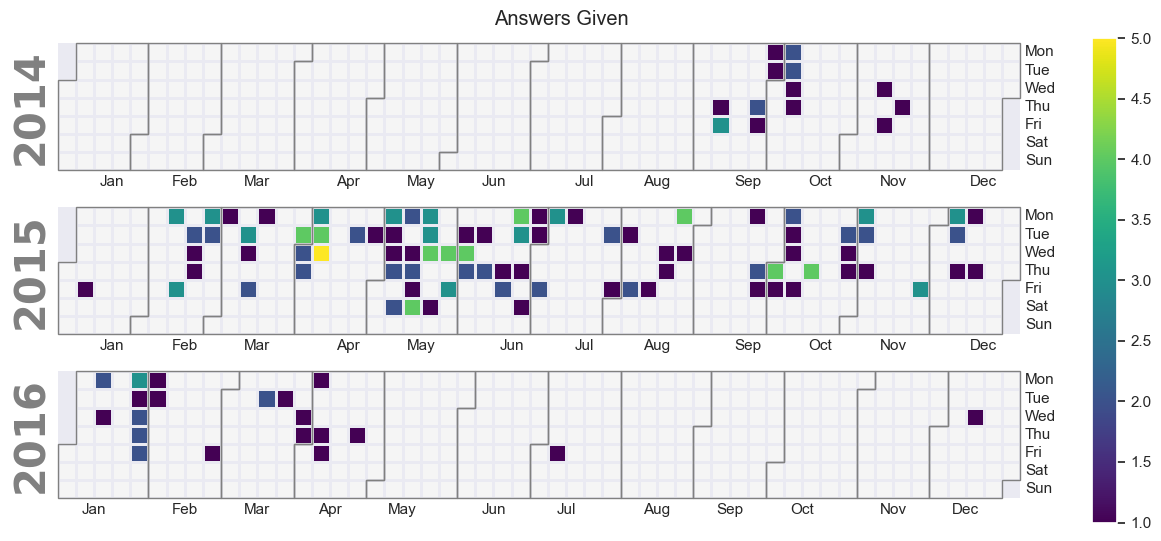

In [54]:
calplot.calplot(answer_events, how=None, suptitle="Answers Given",
                colorbar=answer_events.max() > 1)
plt.show()

## Activity

Time series data of number of various types of activity combined per day visualized as a calendar heatmap.

In [55]:
all_day_entries = [
    joined_day,
    *related_question_days["Questions"],
    *answer_days,
    *other_activity_days
]
first_activity_day = min(all_day_entries)
last_activity_day = max(all_day_entries)

all_activity_days = pd.date_range(first_activity_day, last_activity_day, freq="D")

if VERBOSE:
    print(f"Period of activity: {first_activity_day} - {last_activity_day}")

In [56]:
activity_events = pd.Series(np.zeros(len(all_activity_days)),
                            index=all_activity_days, dtype=int)

for d in all_day_entries:
    activity_events.loc[pd.DatetimeIndex([d])] += 1

if VERBOSE:
    display(activity_events)

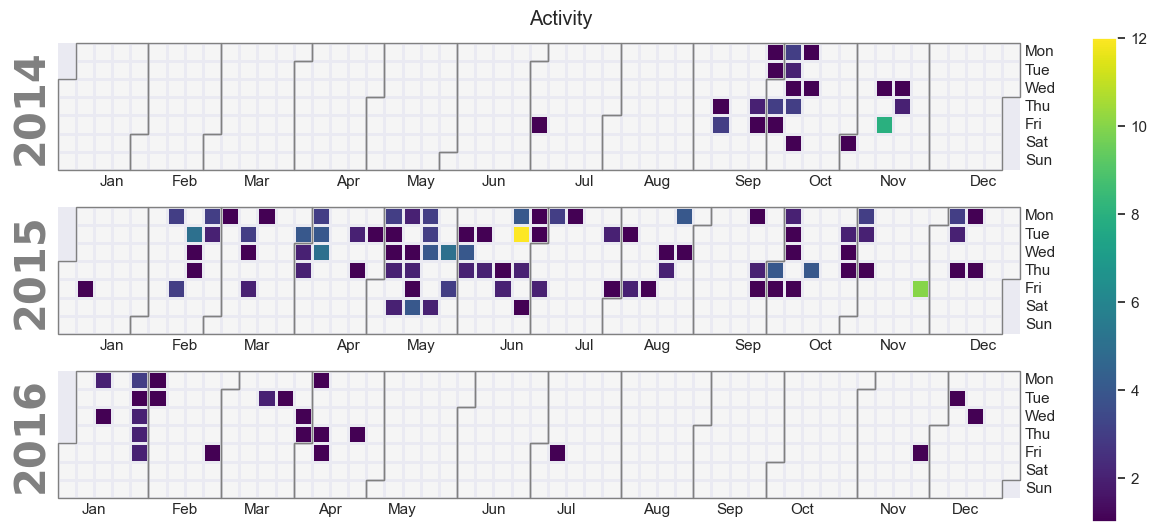

In [57]:
calplot.calplot(activity_events, how=None, suptitle="Activity",
                colorbar=activity_events.max() > 1)
plt.show()

In [58]:
print(f"\n ** Total Elapsed time: {datetime.utcnow() - nb_st} ** \n")
print(f"Notebook END time: {datetime.utcnow()} UTC\n")


 ** Total Elapsed time: 0:13:14.444965 ** 

Notebook END time: 2022-08-20 10:30:30.563277 UTC



In [59]:
%%capture
%mkdir OGP_classic

In [60]:
%%capture
%%file "OGP_classic/conf.json"
{
  "base_template": "classic",
  "preprocessors": {
    "500-metadata": {
      "type": "nbconvert.preprocessors.ClearMetadataPreprocessor",
      "enabled": true,
      "clear_notebook_metadata": true,
      "clear_cell_metadata": true
    },
    "900-files": {
      "type": "nbconvert.preprocessors.ExtractOutputPreprocessor",
      "enabled": true
    }
  }
}

In [61]:
%%capture
%%file "OGP_classic/index.html.j2"
{%- extends 'classic/index.html.j2' -%}
{%- block html_head -%}

{#  OGP attributes for shareability #}
<meta property="og:url"          content="https://sentinel-1.github.io/odoo_forum_user_profile/" />
<meta property="og:type"         content="article" />
<meta property="og:title"        content="User Participation in the Odoo Community Forum" />
<meta property="og:description"  content="Activity statistics visualized in a way similar to GitHub's contributions plot" />
<meta property="og:image"        content="https://raw.githubusercontent.com/sentinel-1/odoo_forum_user_profile/master/images/OdooProfileScreenshot.png" />
<meta property="og:image:alt"    content="Odoo Community Forum Profile Screenshot" />
<meta property="og:image:type"   content="image/png" />
<meta property="og:image:width"  content="1302" />
<meta property="og:image:height" content="987" />
    
<meta property="article:published_time" content="2022-08-20T09:59:43+00:00" />
<meta property="article:modified_time"  content="{{ resources.iso8610_datetime_utcnow }}" />
<meta property="article:publisher"      content="https://sentinel-1.github.io" />
<meta property="article:author"         content="https://github.com/sentinel-1" />
<meta property="article:section"        content="datascience" />
<meta property="article:tag"            content="datascience" />
<meta property="article:tag"            content="Python" />
<meta property="article:tag"            content="data" />
<meta property="article:tag"            content="timeseries" />
<meta property="article:tag"            content="analytics" />
<meta property="article:tag"            content="datavisualization" />
<meta property="article:tag"            content="bigdataunit" />
<meta property="article:tag"            content="visualization" />
<meta property="article:tag"            content="webscraping" />
<meta property="article:tag"            content="odoo" />
<meta property="article:tag"            content="forum" />
<meta property="article:tag"            content="user" />


<link rel="icon" type="image/x-icon" href="../favicon.ico">

{{ super() }}

{%- endblock html_head -%}
    
    
{% block body_header %}
<body>
    
<div class="container">
  <nav class="navbar navbar-default">
    <div class="container-fluid">
      <ul class="nav nav-pills  navbar-left">
        <li role="presentation">
          <a href="/">
            <svg xmlns="http://www.w3.org/2000/svg"
                 viewBox="0 0 576 512" width="1em">
              <path 
                fill="#999999"
d="M 288,0 574,288 511,288 511,511 352,511 352,352 223,352 223,511 62,511 64,288 0,288 Z"
              />
            </svg> Home
          </a>
        </li>
      </ul>
      <ul class="nav nav-pills  navbar-right">
        <li role="presentation" class="active">
          <a href="/odoo_forum_user_profile/">🇬🇧 English </a>
        </li>
        <li role="presentation">
          <a href="/odoo_forum_user_profile/ka/">🇬🇪 ქართული</a>
        </li>
      </ul>
    </div>
  </nav>
</div>



  <div tabindex="-1" id="notebook" class="border-box-sizing">
    <div class="container" id="notebook-container">    
{% endblock body_header %}

{% block body_footer %}
    </div>
  </div>
  <footer>
    <div class="container"
         style="display:flex; flex-direction: row; justify-content: center; align-items: center;">
      <p style="margin: 3.7em auto;"> © 2022
        <a href="https://github.com/sentinel-1" target="_blank">Sentinel-1</a>
      </p>
      <!-- TOP.GE ASYNC COUNTER CODE -->
      <div id="top-ge-counter-container" data-site-id="116052"
           style="margin-right: 3.7em;float: right;"></div>
      <script async src="//counter.top.ge/counter.js"></script>
      <!-- / END OF TOP.GE COUNTER CODE -->
      <!-- ANALYTICS.LAGOGAL.COM -->
      <div id="analytics-lagogal-com-access" data-site-id="20221"
           style="margin: 0;padding: 0;"></div>
      <script async src="//analytics.lagogal.com/access.js"></script>
      <!-- / END OF ANALYTICS.LAGOGAL.COM -->
     </div>
  </footer>
</body>
{% endblock body_footer %}


*This notebook is originally published under the Apache License (Version 2.0) at the following GitHub repository: [sentinel-1/odoo_forum_user_profile](https://github.com/sentinel-1/odoo_forum_user_profile)*

For the issues, feedback or suggestions regarding the original notebook (if any) feel free to open an issue at the corresponding [Issues page of the repository](https://github.com/sentinel-1/odoo_forum_user_profile/issues)